# **Socio-economic Factors for Geographic Clustering**

-----------------------------------------
## **Context**
-----------------------------------------

This case study delves into a dataset encompassing diverse socio-economic attributes of countries worldwide. Understanding and influencing the future of societies is crucial for both government and non-government institutions. Although GDP is a widely used economic metric, this study recognizes the need to explore multiple indicators to comprehensively assess economic growth and a nation's state.

-----------------------------------------
## **Objective**
-----------------------------------------

The primary objective is to categorize countries based on socio-economic and health factors, identifying distinct clusters to pinpoint nations in need of targeted assistance for overall development.

------------------------
## **Data Dictionary**
-------------------------
The data has the following attributes:
- country: Name of the country
- child_mort: Death of children under 5 years of age per 1000 live births
- exports - Exports in % of the GDP per capita
- health - The total spend on health given as % of GDP
- imports - The value of imports given as % of GDP per capita
- income - The net income per person
- inflation - Inflation rate %
- life_expec - Average life expectancy in years
- total_fer - The fertility rate - Average children per woman in the country
- gdpp - GDP per capita



## Importing Libraries and Data overview

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from kneed import KneeLocator

In [3]:
df = pd.read_csv(r"C:\Users\lenovo\Desktop\Einstein\Projects\Clustering\Country-data.csv")

In [4]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
df.duplicated().sum()

0

The data is free from missing values and there are no duplicates.

# EDA

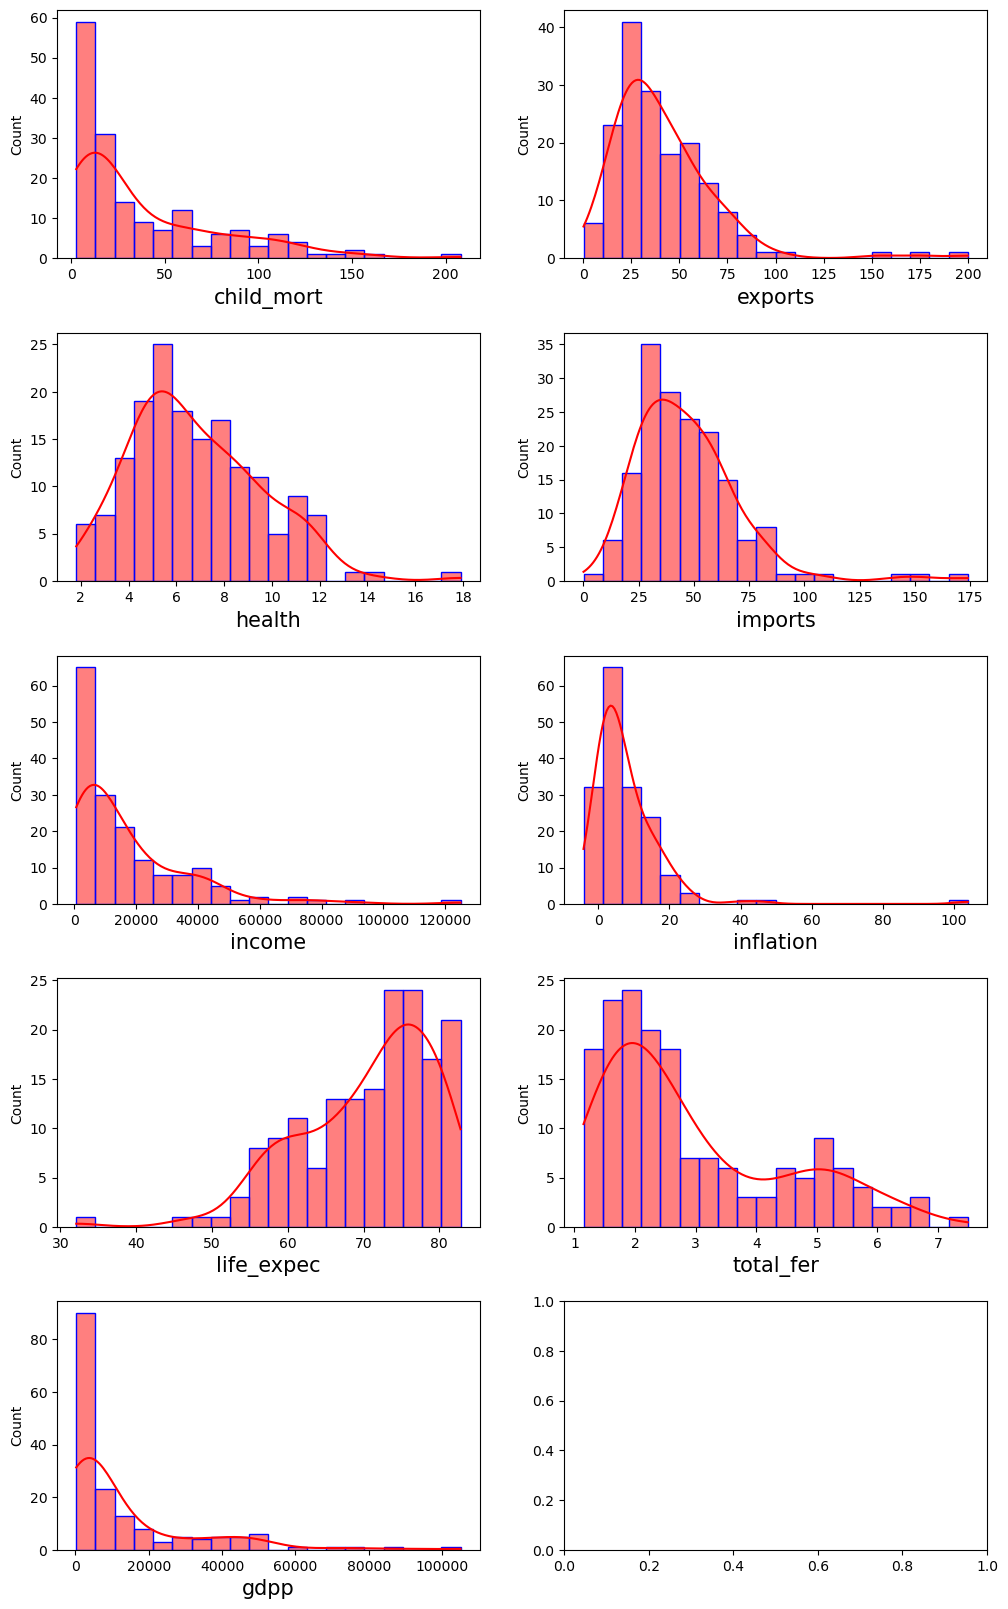

In [8]:
# Check distribution using histogram
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (12, 20))

axes = axes.flatten()

for i, col in enumerate(df.columns[1:]):
    sns.histplot(df[col], bins = 20, kde = True, color = 'red', ax = axes[i], edgecolor = 'blue')
    axes[i].set_xlabel(col, fontsize = 15)

    

fig.subplots_adjust(hspace = 0.3)

In [15]:
# Top 10 Countries with highest child mortality rate.
top_child_mort = df.sort_values('child_mort', ascending = False).head(10)[['country', 'child_mort']].reset_index(drop = True)

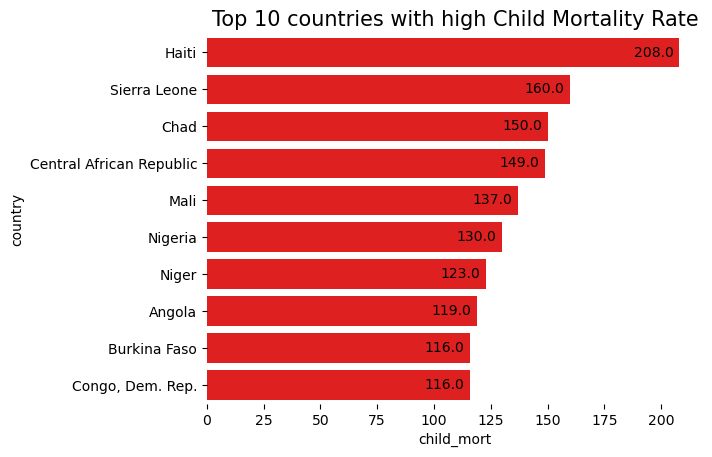

In [16]:
sns.barplot(data = top_child_mort, y = 'country', x = 'child_mort', color = 'red')
plt.title('Top 10 countries with high Child Mortality Rate', fontsize = 15)

for i in range(len(top_child_mort)):
    text = top_child_mort.iloc[i, 1]
    plt.annotate(text, xy = (text - 20, i + 0.1), color = 'black')
    
plt.box(False)

In [23]:
# Top 10 countries with highest GDP per Capita.
top_gdpp = df.nlargest(10, 'gdpp')[['country', 'gdpp']].set_index('country').sort_values('gdpp')

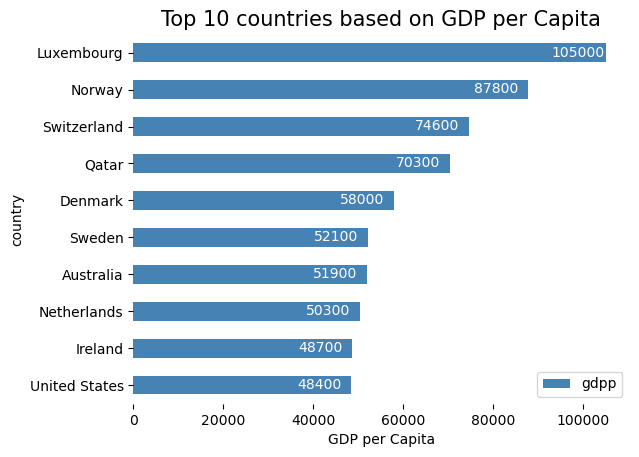

In [24]:
top_gdpp.plot(kind = 'barh', color = 'steelblue')
plt.xlabel('GDP per Capita')
plt.title('Top 10 countries based on GDP per Capita', fontsize = 15)

for i in range(len(top_gdpp)):
    text = top_gdpp.iloc[i][0]
    plt.annotate(text, xy = (text - 12000, i - 0.1), color = 'white')
    
plt.box(False)

In [25]:
# Bottom 10 Countries with lowest GDB per Capita.
bottom_gdpp = df.nsmallest(10, 'gdpp')[['country', 'gdpp']].set_index('country')

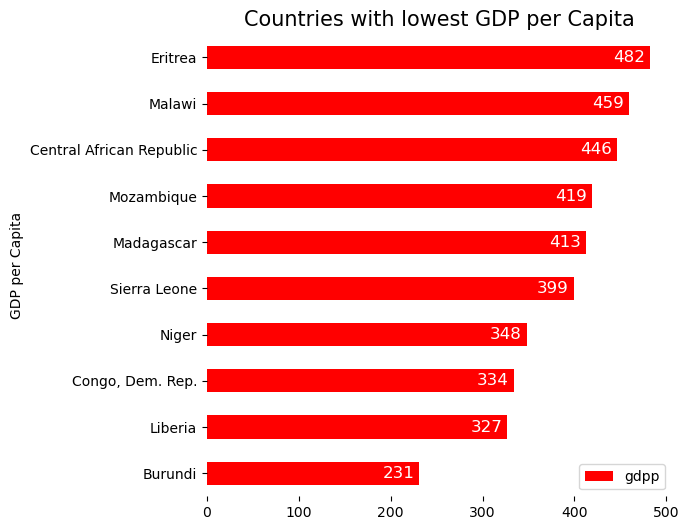

In [26]:
bottom_gdpp.plot(kind = 'barh', 
                 color = 'red',
                 xlabel = 'GDP per Capita', figsize = (6, 6))
plt.title('Countries with lowest GDP per Capita', fontsize = 15)
plt.box(False)

for i in range(len(bottom_gdpp)):
    text = bottom_gdpp.iloc[i][0]
    plt.annotate(text, xy = (text - 40, i - 0.1), color = 'white', fontsize = 12)

### Outlier Analysis

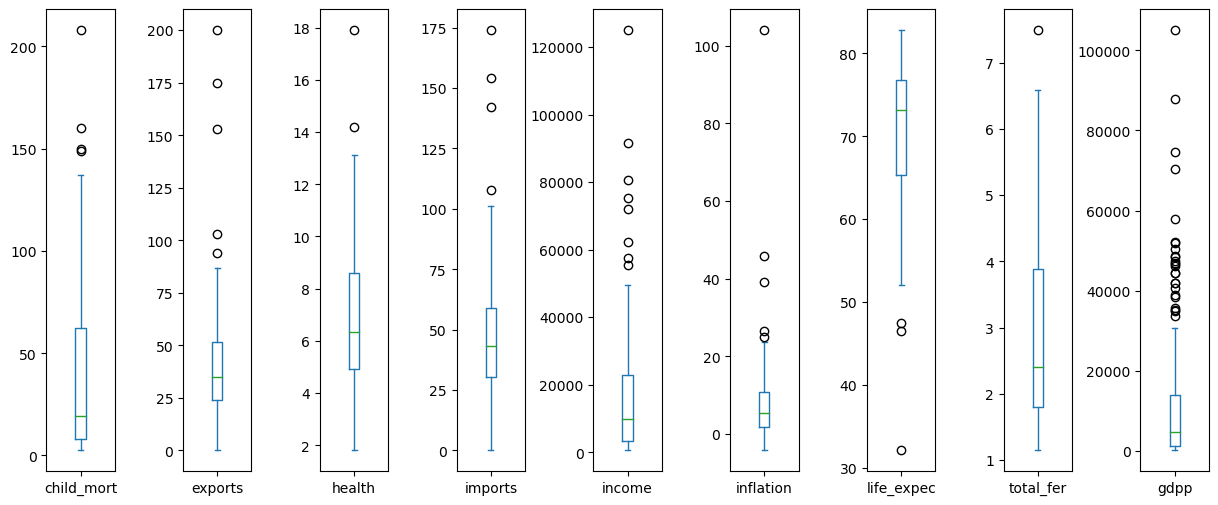

In [27]:
df.plot(kind = 'box', subplots = True, figsize = (15, 6))
plt.subplots_adjust(wspace = 1)

In [14]:
# Outlier count for each column.

outlier_count = {}

for col in df.columns[1:]:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)

    lower_min = q1 - (1.5 * iqr)
    upper_max = q3 + (1.5 * iqr)
    outlier_count[col] = len(df[(df[col] < lower_min) | (df[col] > upper_max)])
    
outlier_count = pd.DataFrame(outlier_count, index = ['outliers']).T
outlier_count.sort_values('outliers', ascending = False)

,outliers
gdpp,25
income,8
exports,5
inflation,5
child_mort,4
imports,4
life_expec,3
health,2
total_fer,1


In [15]:
# Outlier countries based on gdpp

q1 = df['gdpp'].quantile(0.25)
q3 = df['gdpp'].quantile(0.75)
iqr = df['gdpp'].quantile(0.75) - df['gdpp'].quantile(0.25)

lower_min = q1 - (1.5 * iqr)
upper_max = q3 + (1.5 * iqr)

df[(df['gdpp'] < lower_min) | (df['gdpp'] > upper_max)].sort_values(by = 'gdpp', ascending = False)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000
114,Norway,3.2,39.7,9.48,28.5,62300,5.950,81.0,1.95,87800
145,Switzerland,4.5,64.0,11.50,53.3,55500,0.317,82.2,1.52,74600
123,Qatar,9.0,62.3,1.81,23.8,125000,6.980,79.5,2.07,70300
44,Denmark,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000
144,Sweden,3.0,46.2,9.63,40.7,42900,0.991,81.5,1.98,52100
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900
110,Netherlands,4.5,72.0,11.90,63.6,45500,0.848,80.7,1.79,50300
73,Ireland,4.2,103.0,9.19,86.5,45700,-3.220,80.4,2.05,48700
159,United States,7.3,12.4,17.90,15.8,49400,1.220,78.7,1.93,48400


###  Observation

+ Child mortality rate has right skewed distribution that means most countries have low child mortality rate, with a few having very high rate. Similar pattern can be observed in the distribution of other metrics except for Life Expectancy as most of the countries have relatively high life expectancy.


+ **gdpp**  is the most significant attribute in terms of outliers, as it has a significantly huge number of outliers in comparison with other attributes. We will analyse cluster both ways, with gdpp and without gdpp, so that we get an idea of how gdpp is affecting our clusters.

## Correlation Analysis

<AxesSubplot:>

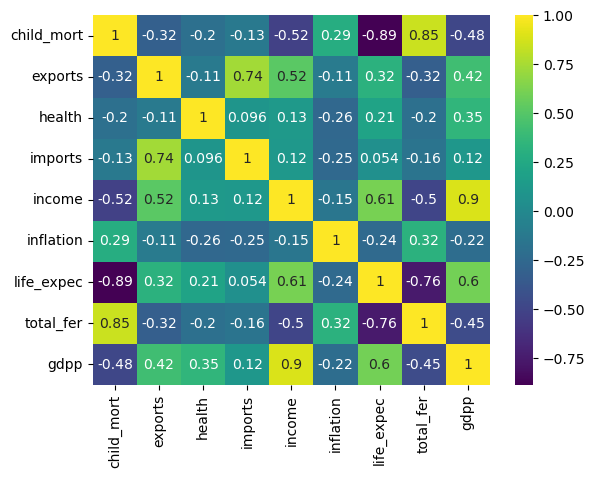

In [16]:
sns.heatmap(df.corr(), annot = True, cmap = 'viridis')

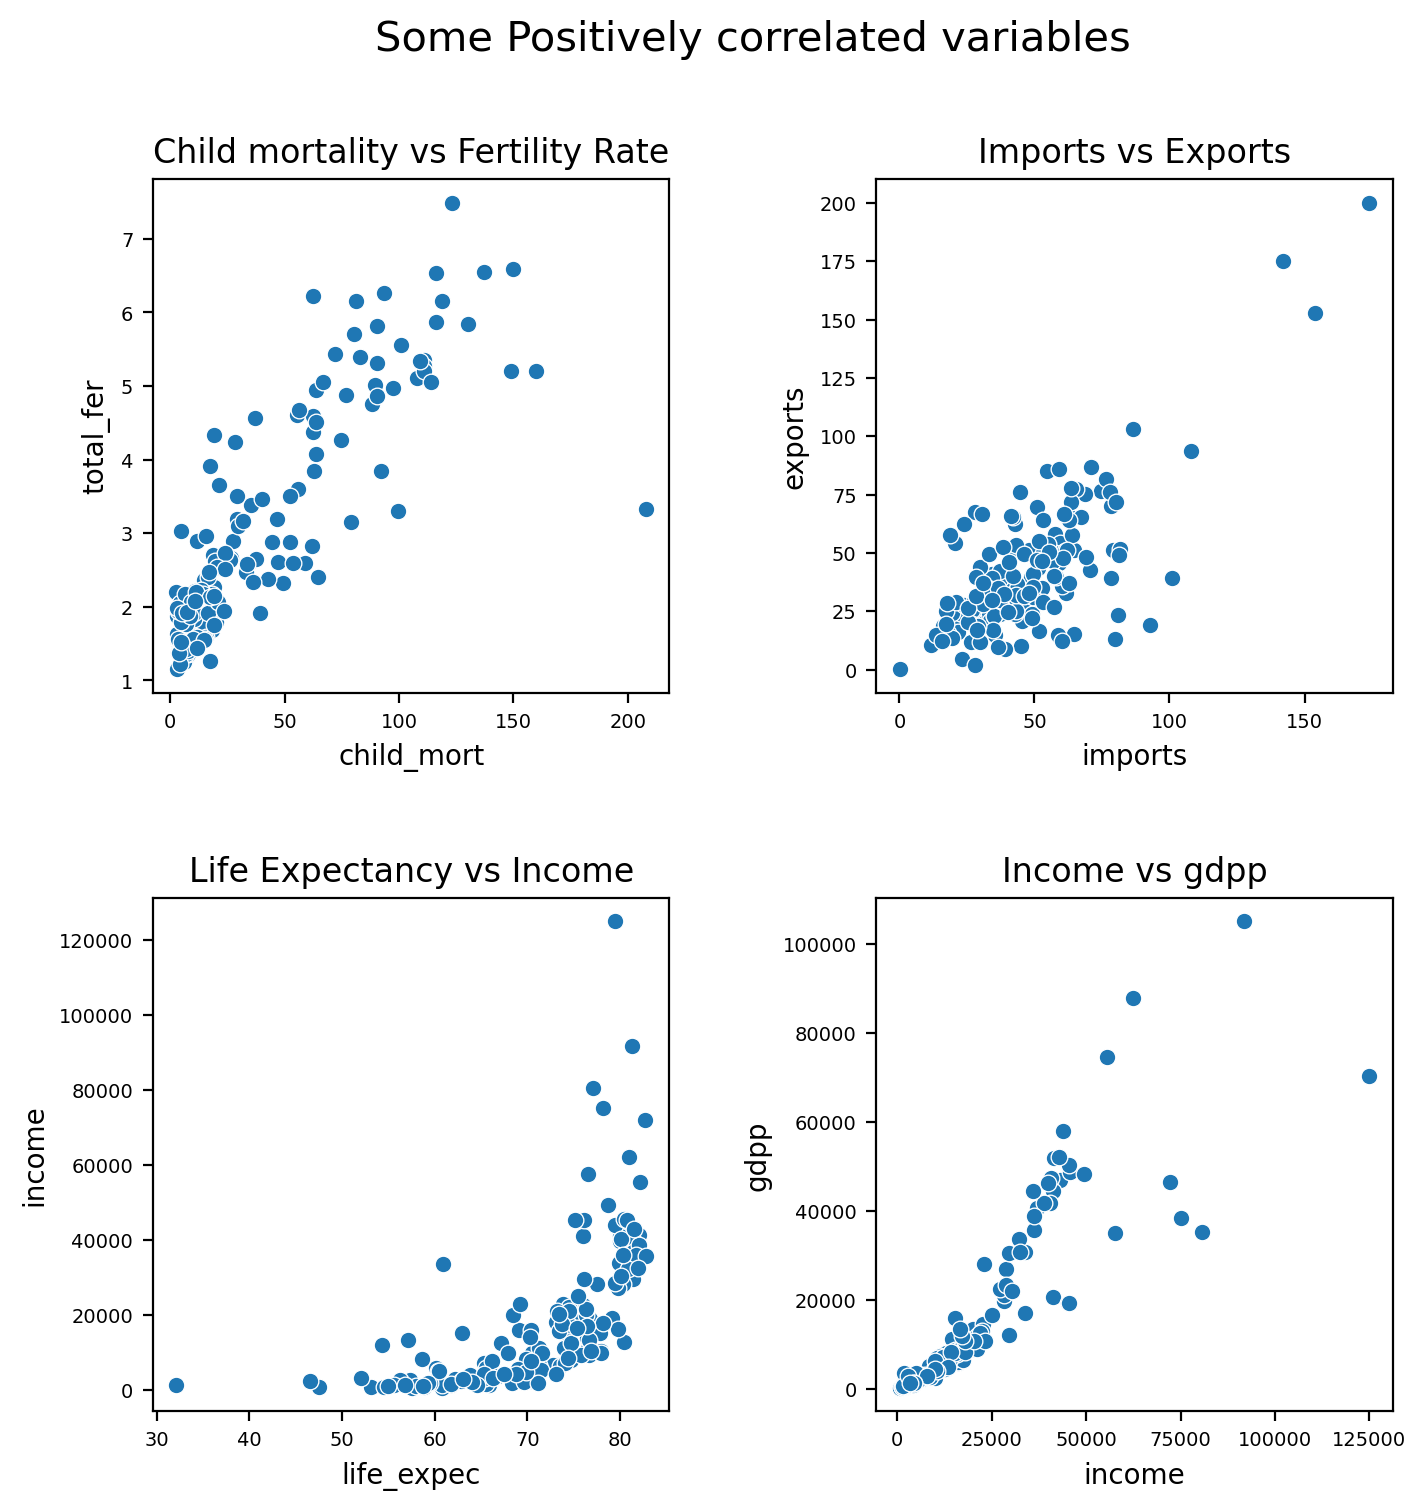

In [35]:
plt.figure(figsize = (8, 8), dpi = 200)

plt.subplot(2,2,1)
a = sns.scatterplot(x = df['child_mort'], y = df['total_fer'])
a.set_title('Child mortality vs Fertility Rate')
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)


plt.subplot(2,2,2)
b = sns.scatterplot(x = df['imports'], y = df['exports'])
b.set_title('Imports vs Exports')
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)


plt.subplot(2,2,3)
c = sns.scatterplot(x = df['life_expec'], y = df['income'])
c.set_title('Life Expectancy vs Income')
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)


plt.subplot(2,2,4)
d = sns.scatterplot(x = df['income'], y = df['gdpp'])
d.set_title('Income vs gdpp')
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)



plt.suptitle('Some Positively correlated variables', fontsize = 15)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
# plt.tight_layout()

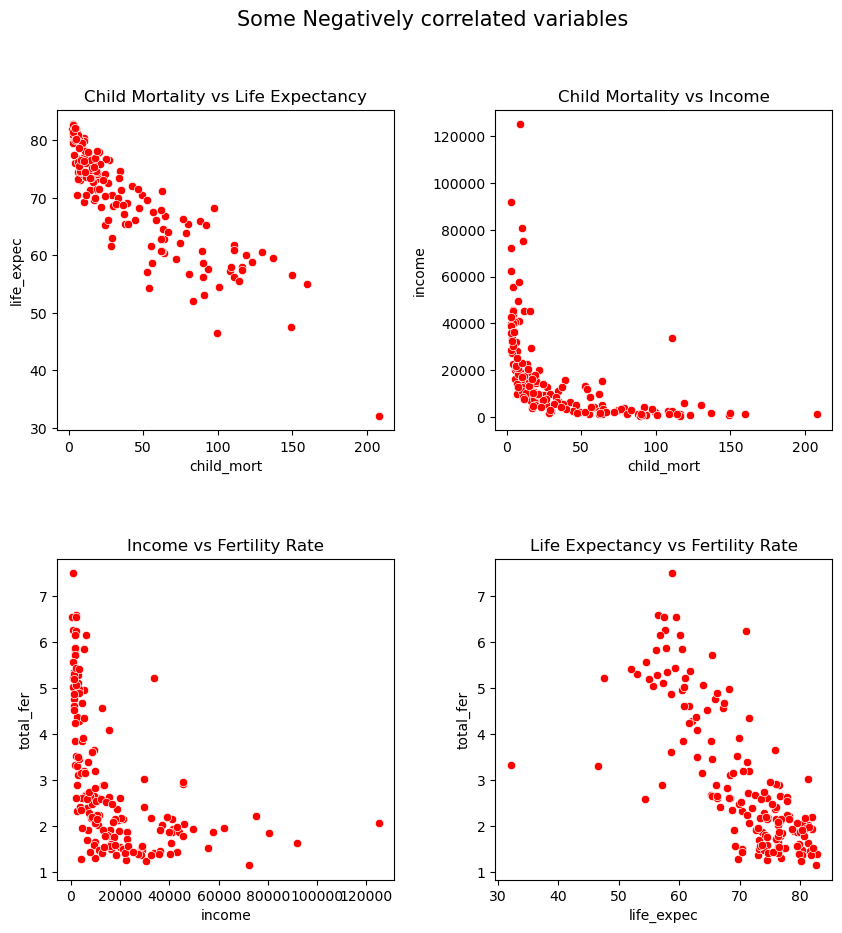

In [38]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

sns.scatterplot(x = df['child_mort'], y = df['life_expec'], ax = axes[0,0], color = 'red')
axes[0,0].set_title('Child Mortality vs Life Expectancy')

sns.scatterplot(x = df['child_mort'], y = df['income'], ax = axes[0,1], color = 'red')
axes[0,1].set_title('Child Mortality vs Income')

sns.scatterplot(x = df['income'], y = df['total_fer'], ax = axes[1,0], color = 'red')
axes[1,0].set_title('Income vs Fertility Rate')

sns.scatterplot(x = df['life_expec'], y = df['total_fer'], ax = axes[1,1], color = 'red')
axes[1,1].set_title('Life Expectancy vs Fertility Rate')


plt.suptitle('Some Negatively correlated variables', fontsize = 15)
plt.subplots_adjust(wspace = 0.3, hspace = 0.4)


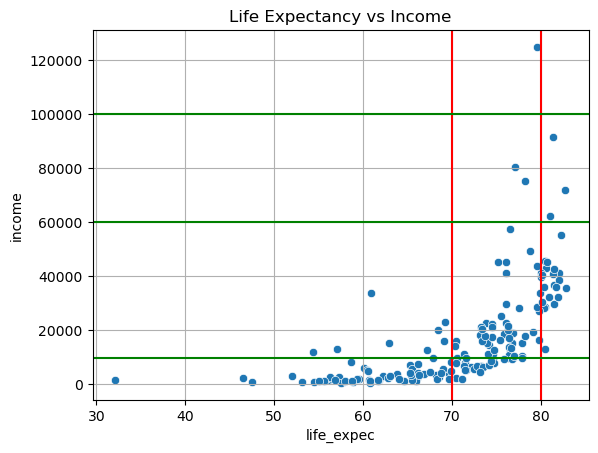

In [19]:
sns.scatterplot(x = df['life_expec'], y = df['income'])
plt.title('Life Expectancy vs Income')
plt.axvline(70, color = 'red')
plt.axvline(80, color = 'red')
plt.axhline(100000, color = 'green')
plt.axhline(60000, color = 'green')
plt.axhline(df['income'].median(), color = 'green')
plt.grid()

In [20]:
# Country with Extremely low income and life expectancy
df.loc[(df['life_expec'] < 40) & (df['income'] < 20000)]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
66,Haiti,208.0,15.3,6.91,64.7,1500,5.45,32.1,3.33,662


In [21]:
df.loc[(df['income'] > 100000)]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
123,Qatar,9.0,62.3,1.81,23.8,125000,6.98,79.5,2.07,70300


In [39]:
df.loc[(df['life_expec'] > 79) & (df['income'] >= 60000)]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000
114,Norway,3.2,39.7,9.48,28.5,62300,5.950,81.0,1.95,87800
123,Qatar,9.0,62.3,1.81,23.8,125000,6.980,79.5,2.07,70300
133,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600


In [23]:
df.loc[(df['life_expec'] > 79) & (df['income'] < 60000)].shape

(28, 10)

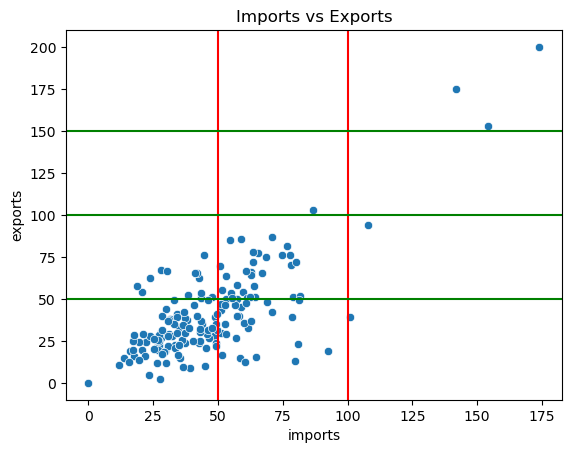

In [41]:
# Ins and Outs
sns.scatterplot(x = df['imports'], y = df['exports'])
plt.title('Imports vs Exports')
plt.axvline(50, color = 'red')
plt.axvline(100, color = 'red')
plt.axhline(50, color = 'green')
plt.axhline(100, color = 'green')
plt.axhline(150, color = 'green')
# plt.grid()

### Observations:  

* Life expectancy has negative correlation with fertility rate. 
* Fertility Rate decreases with income, that means people with high income tend to have less kids (Family planning).
* Life Expectancy is positively correlated with Income, but countries with moderate income have higher life expectancy than those outlier high income countries.
* Most countries seem to have a good balance between what they bring in as imports and what they send out as exports.

# Clustering with gdpp data

## Standardizing

In [9]:
data_with_gdpp = df.iloc[:, 1:].copy(deep = True)
std = StandardScaler()

data_with_gdpp = pd.DataFrame(std.fit_transform(data_with_gdpp), columns = data_with_gdpp.columns)
data_with_gdpp.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


## KMeans 

Elbow is at 4


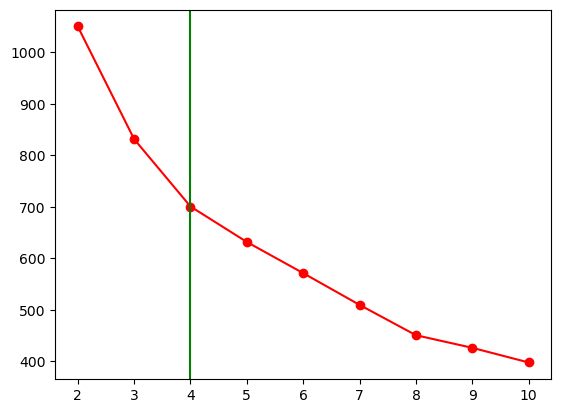

In [10]:
#WCSS is used to find optimum number of clusters, we will also use kneelocator to reduce visual discomfort in finding elbow.
wcss = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 11)
    kmeans.fit(data_with_gdpp)
    wcss.append(kmeans.inertia_)
    
knee = KneeLocator(range(2, 11), wcss, curve = 'convex', direction = 'decreasing')
print(f'Elbow is at {knee.elbow}')
plt.plot(range(2, 11), wcss, 'ro-')
plt.axvline(knee.elbow, color = 'green')
plt.show()

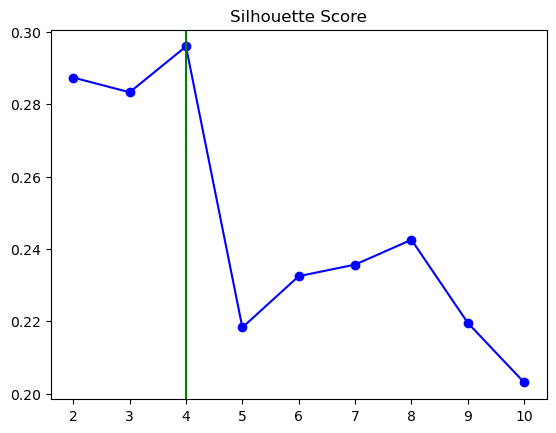

In [11]:
# Silhoutte Score
silhouette= []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 11)
    kmeans.fit(data_with_gdpp)
    score = silhouette_score(data_with_gdpp, kmeans.labels_)
    silhouette.append(score)
    
plt.plot(range(2, 11), silhouette, 'bo-')
plt.title('Silhouette Score')
plt.axvline(silhouette.index(max(silhouette)) + 2, color = 'green')  # drop line

* Since both WCSS and Silhouette say k should be 4, let's proceed with 4.

### Final model

In [12]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 1)
kmeans.fit(data_with_gdpp)
labels = kmeans.labels_

In [13]:
final_with_gdpp = df.copy(deep = True)
final_with_gdpp['cluster'] = labels

In [14]:
final_with_gdpp.value_counts('cluster')

cluster
3    85
1    47
0    32
2     3
dtype: int64

In [15]:
final_with_gdpp

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,3
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,3
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,3
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,3
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,3
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,3
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,1


# Clustering without gdpp data

## Standardizing

In [16]:
data_without_gdpp = df.iloc[:, 1: df.shape[1] - 1 ]

data_without_gdpp = pd.DataFrame(std.fit_transform(data_without_gdpp), columns = data_without_gdpp.columns)

In [17]:
data_without_gdpp.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946


## Model

In [18]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 1)
kmeans.fit(data_without_gdpp)
labels = kmeans.labels_

In [19]:
final_without_gdpp = df.copy(deep = True)
final_without_gdpp['cluster'] = labels

In [20]:
final_without_gdpp.value_counts('cluster')

cluster
0    83
1    47
3    34
2     3
dtype: int64

# Comparison

In [21]:
final_with_gdpp.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,3
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,3
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,3


In [22]:
final_without_gdpp.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


In [51]:
with_gdp = final_with_gdpp.value_counts('cluster').reset_index().rename(columns = {'cluster' : 'cluster_with_gdpp', 0 : 'No_of_countries'})
without_gdp = final_without_gdpp.value_counts('cluster').reset_index().rename(columns = {'cluster' : 'cluster_without_gdpp', 0 : 'No_of_countries'})

pd.concat([with_gdp, without_gdp], axis = 1)

,cluster_with_gdpp,No_of_countries,cluster_without_gdpp,No_of_countries
0,3,85,0,83
1,1,47,1,47
2,0,32,3,34
3,2,3,2,3


In [59]:
final_with_gdpp.groupby('cluster').mean().T

cluster,0,1,2,3
child_mort,5.181250,92.961702,4.133333,21.690588
exports,46.118750,29.151277,176.000000,41.073988
health,9.088437,6.388511,6.793333,6.197059
imports,40.584375,42.323404,156.666667,47.914893
income,44021.875000,3942.404255,64033.333333,12671.411765
inflation,2.513844,12.019681,2.468000,7.609341
life_expec,80.081250,59.187234,81.433333,72.871765
total_fer,1.788437,5.008085,1.380000,2.300706
gdpp,42118.750000,1922.382979,57566.666667,6519.552941


As per the table above it can be inferred that the countries which belong to cluster 1 are in high need of assistance for their overall development, due to their poor socio-economic conditions. And countries belonging to cluster 2 are highly developed prosperous nations.   
Let's label all the clusters accordingly for easy identification.

+ cluster 0 is Developed (32 countries)
+ cluster 1 is Underdeveloped (47 countries)
+ cluster 2 is prosperous (3 countries)
+ cluster 3 is Developing (85 countries)

In [43]:
final_with_gdpp.loc[final_with_gdpp['cluster'] == 0, 'cluster_label'] = 'Developed'
final_with_gdpp.loc[final_with_gdpp['cluster'] == 1, 'cluster_label'] = 'Underdeveloped'
final_with_gdpp.loc[final_with_gdpp['cluster'] == 2, 'cluster_label'] = 'Prosperous'
final_with_gdpp.loc[final_with_gdpp['cluster'] == 3, 'cluster_label'] = 'Developing'

In [44]:
final_with_gdpp['cluster_label'].value_counts()

Developing        85
Underdeveloped    47
Developed         32
Prosperous         3
Name: cluster_label, dtype: int64

In [33]:
final_without_gdpp.groupby('cluster').mean().T

cluster,0,1,2,3
child_mort,22.089157,92.961702,4.133333,5.179412
exports,40.808301,29.151277,176.000000,46.470588
health,6.070482,6.388511,6.793333,9.227353
imports,47.618866,42.323404,156.666667,41.738235
income,12675.301205,3942.404255,64033.333333,42168.235294
inflation,7.686096,12.019681,2.468000,2.626206
life_expec,72.713253,59.187234,81.433333,80.044118
total_fer,2.322410,5.008085,1.380000,1.765588
gdpp,6659.662651,1922.382979,57566.666667,39682.647059


Data without gdpp: Cluster labels as per above table  

+ cluster 0 is Developing (83)
+ cluster 1 is Underdeveloped (47)
+ cluster 2 is prosperous (3)
+ cluster 3 is Developed (34)

In [42]:
final_without_gdpp.loc[final_without_gdpp['cluster'] == 0, 'cluster_label'] = 'Developing'
final_without_gdpp.loc[final_without_gdpp['cluster'] == 1, 'cluster_label'] = 'Underdeveloped'
final_without_gdpp.loc[final_without_gdpp['cluster'] == 2, 'cluster_label'] = 'Prosperous'
final_without_gdpp.loc[final_without_gdpp['cluster'] == 3, 'cluster_label'] = 'Developed'

In [45]:
final_without_gdpp['cluster_label'].value_counts()

Developing        83
Underdeveloped    47
Developed         34
Prosperous         3
Name: cluster_label, dtype: int64

## gdpp influence on Clusters:

Let's analyse what is the impact of gdpp on the clustering splits, to what extent does gdpp's cluster differ from the cluster made without considering gdpp.

In [46]:
# Analyze overlap of Under developed countries.
with_gdpp = final_with_gdpp.loc[final_with_gdpp['cluster_label'] == 'Underdeveloped', 'country'].tolist()
without_gdpp = final_without_gdpp.loc[final_without_gdpp['cluster_label'] == 'Underdeveloped', 'country'].tolist()

common_countries = set(with_gdpp).intersection(set(without_gdpp))
overlap = len(common_countries)/ len(with_gdpp) * 100

print(f'Number of common countries: {len(common_countries)}' )
print(f'percentage of countries common in both cases: {round(overlap)}%')

Number of common countries: 47
percentage of countries common in both cases: 100%


In [47]:
# Analyze overlap of Developing countries.
with_gdpp = final_with_gdpp.loc[final_with_gdpp['cluster_label'] == 'Developing', 'country'].tolist()
without_gdpp = final_without_gdpp.loc[final_without_gdpp['cluster_label'] == 'Developing', 'country'].tolist()

common_countries = set(with_gdpp).intersection(set(without_gdpp))
overlap = len(common_countries)/ len(with_gdpp) * 100

print(f'Number common countries: {len(common_countries)}' )
print(f'percentage of countries common in both cases: {round(overlap)}%')

Number common countries: 82
percentage of countries common in both cases: 96%


In [48]:
# Analyze overlap of Developed countries.
with_gdpp = final_with_gdpp.loc[final_with_gdpp['cluster_label'] == 'Developed', 'country'].tolist()
without_gdpp = final_without_gdpp.loc[final_without_gdpp['cluster_label'] == 'Developed', 'country'].tolist()

common_countries = set(with_gdpp).intersection(set(without_gdpp))
overlap = len(common_countries)/ len(without_gdpp) * 100

print(f'Number common countries: {len(common_countries)}' )
print(f'percentage of countries common in both cases: {round(overlap)}%')

Number common countries: 31
percentage of countries common in both cases: 91%


In [49]:
# Analyze overlap of Prosperous countries.
with_gdpp = final_with_gdpp.loc[final_with_gdpp['cluster_label'] == 'Prosperous', 'country'].tolist()
without_gdpp = final_without_gdpp.loc[final_without_gdpp['cluster_label'] == 'Prosperous', 'country'].tolist()

common_countries = set(with_gdpp).intersection(set(without_gdpp))
overlap = len(common_countries)/ len(without_gdpp) * 100

print(f'Number common countries: {len(common_countries)}' )
print(f'percentage of countries common in both cases: {round(overlap)}%')

Number common countries: 3
percentage of countries common in both cases: 100%


#### Conclusion:

It seems that the clustering results are consistent, with approximately 97% of countries falling into the same cluster regardless of whether we consider GDP per Capita as a factor or not. This persistence in cluster assignment suggests a high level of stability in the clustering outcomes. 

 Notably, despite GDP being a widely used economic factor and the dataset containing numerous outliers, its inclusion or exclusion minimally affects the clusters. This observation implies that the clustering outcomes exhibit robustness, with other factors likely exerting a more influential role in determining the final cluster assignments.

<AxesSubplot:xlabel='cluster_label', ylabel='count'>

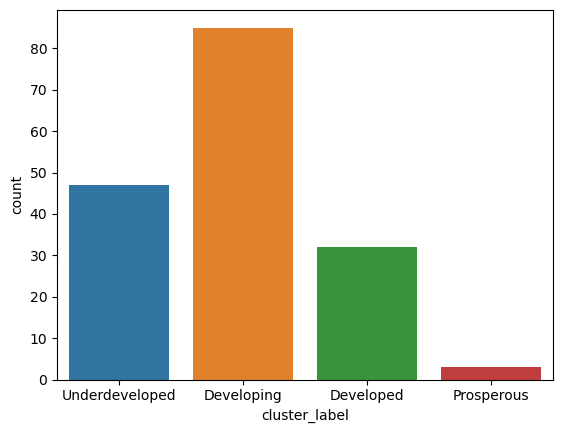

In [73]:
# How are countries distributed among different clusters.
sns.countplot(final_with_gdpp['cluster_label'])

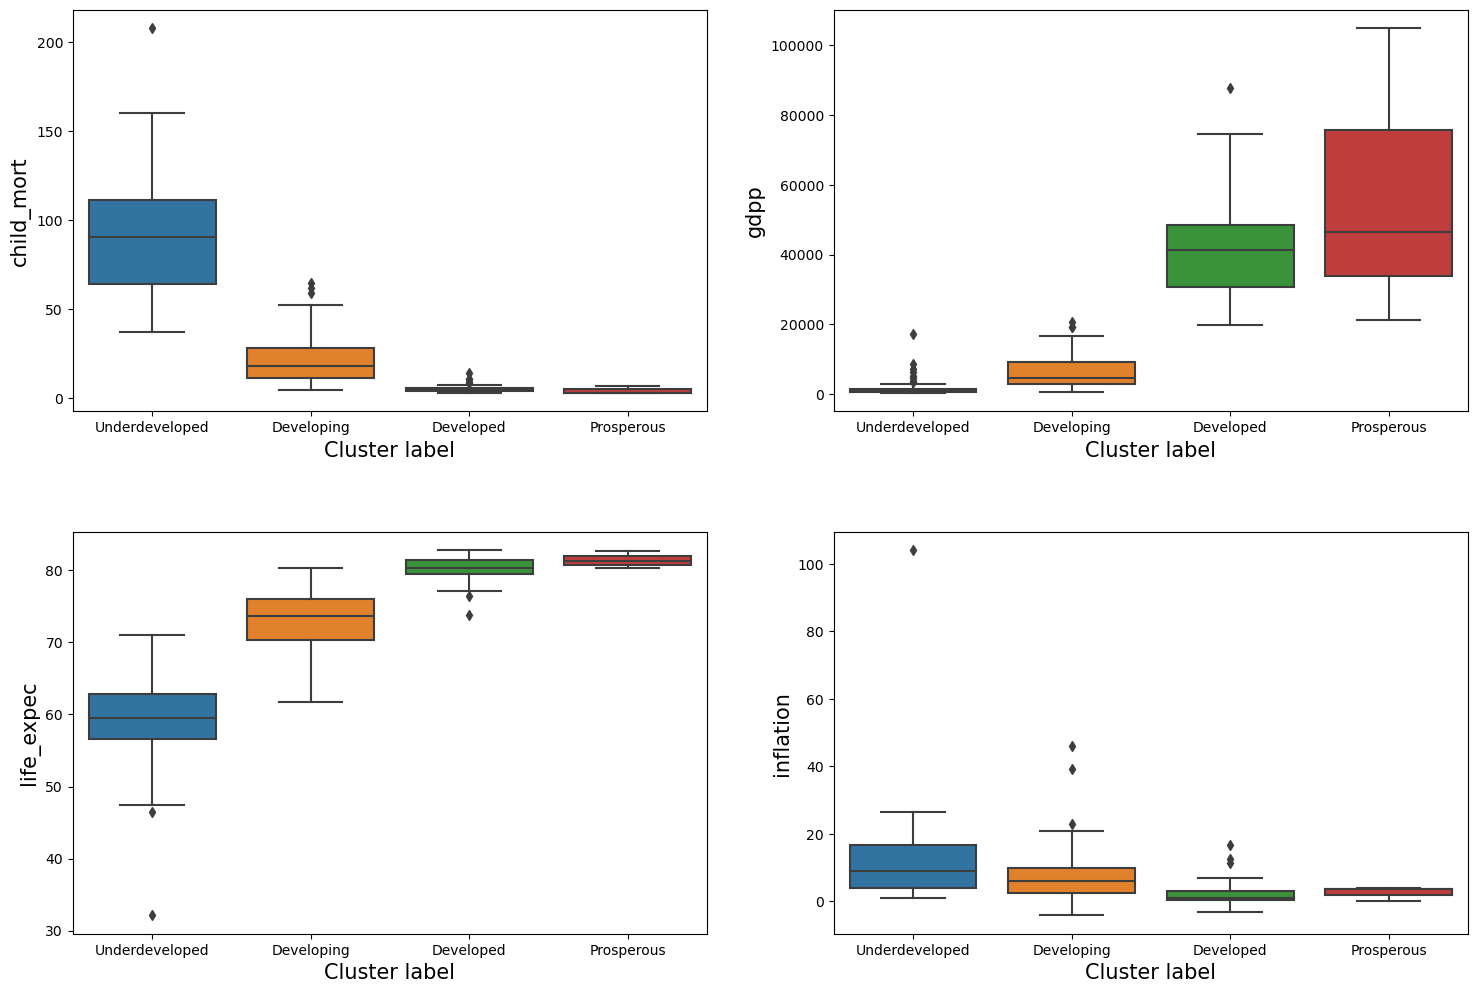

In [83]:
# Distribution of factors among different clusters.
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 12))

axes = axes.flatten()

clusters = final_with_gdpp['cluster_label']
columns = ['child_mort', 'gdpp', 'life_expec', 'inflation']


for i, col in enumerate(columns):
    sns.boxplot(x = clusters, y = final_with_gdpp[col], ax = axes[i])
    axes[i].set_ylabel(col, fontsize = 15)
    axes[i].set_xlabel('Cluster label', fontsize = 15)

    

fig.subplots_adjust(hspace = 0.3)

# Countries most in need of help

In [52]:
# There are 47 countries falling in the lowest category as per their socio-economic factors, 
# labelled as 'Under Developed'

underdeveloped = final_with_gdpp.loc[final_with_gdpp['cluster_label'] == 'Underdeveloped']
final_list = final_with_gdpp.loc[final_with_gdpp['cluster_label'] == 'Underdeveloped', 'country'].to_list()

print(final_list)

['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia']


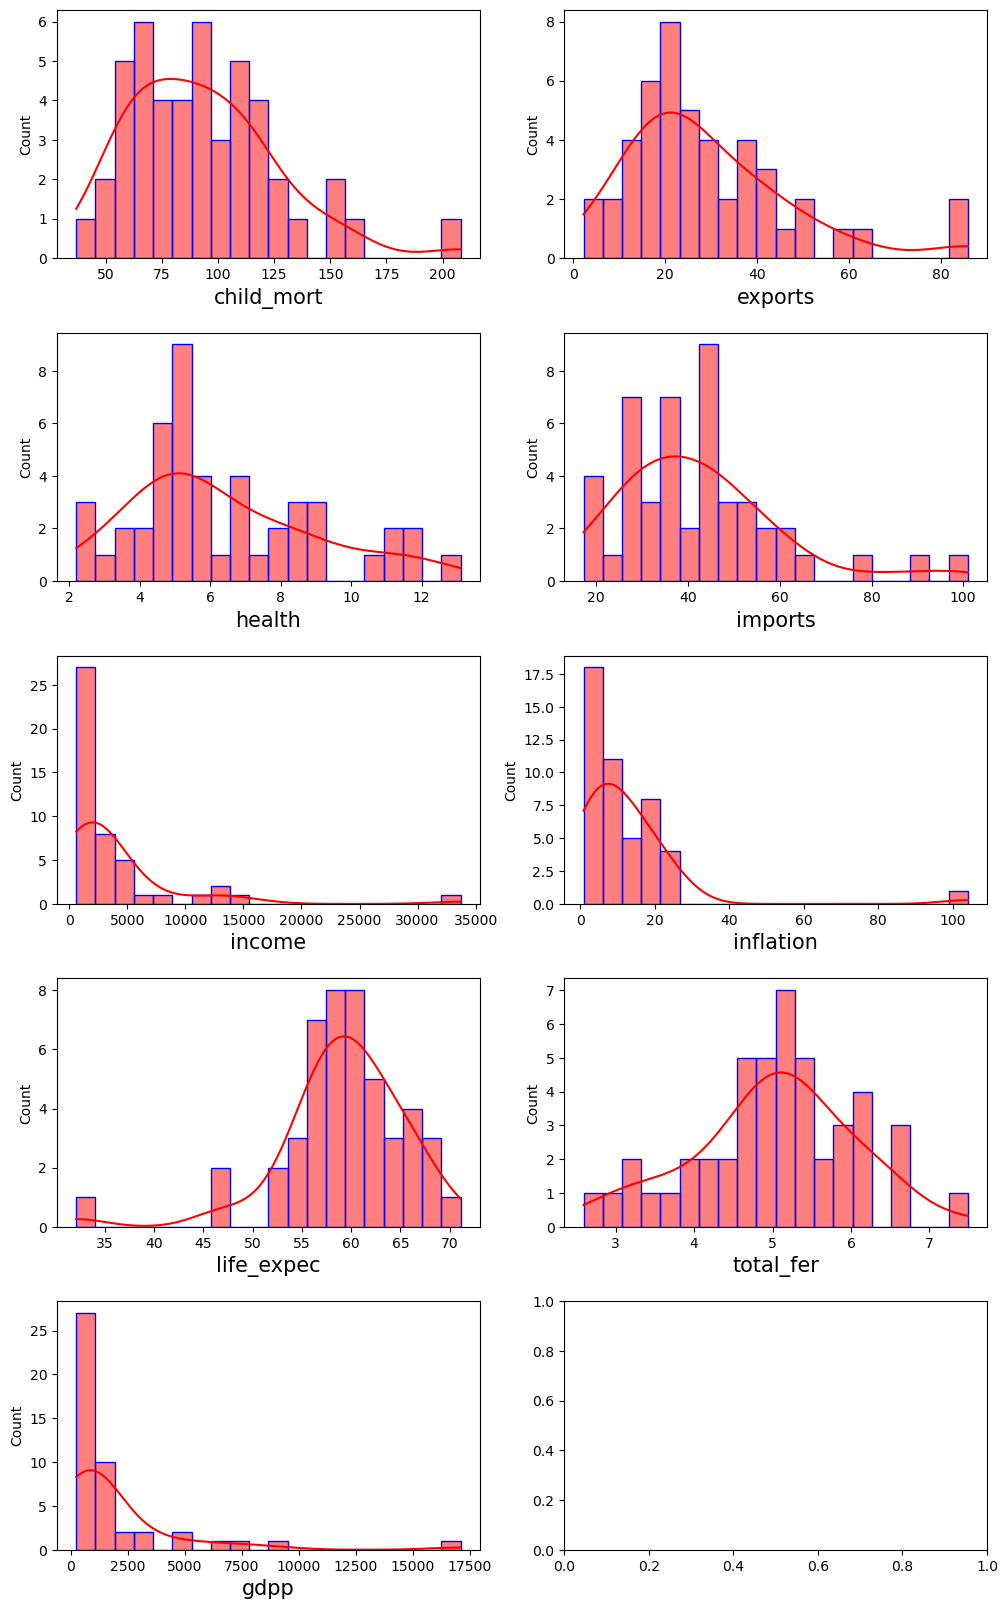

In [87]:
# Check distribution of facctors for Underdeveloped countries using histogram
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (12, 20))

axes = axes.flatten()

columns = ['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp']

for i, col in enumerate(columns):
    sns.histplot(underdeveloped[col], bins = 20, kde = True, color = 'red', ax = axes[i], edgecolor = 'blue')
    axes[i].set_xlabel(col, fontsize = 15)

    
fig.subplots_adjust(hspace = 0.3)

In [88]:
# Saving the data of final shortlisted countries for targeted assistance.
underdeveloped.to_csv('Underdeveloped countries')

## Conclusion 

As per the comparative analysis conducted above, Having a highly skewed GDP per capita as a variable does not cause much difference in seggregating the countries. This indicates that the socio-economic factors considered in this study, are strong enough to seggregate countries for targeted economic assistance.

-----------------

In conclusion, the clustering analysis of socio-economic factors has identified 47 countries grouped under the label "Underdeveloped" Countries. This designation signifies their placement in the lowest category based on socio-economic indicators. 

Moving forward, the allocation of resources will involve a more nuanced classification within this group. By conducting further analysis and classification, we can optimize our efforts and allocate resources effectively to assist the countries most in need. This targeted approach will enable us to address specific socio-economic challenges and tailor interventions to support the development and well-being of these nations.
